In [134]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import mplleaflet

## Step 1: Define Helper Functions

In [2]:
# csv_files_2017 = [('2017' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
# csv_files_2018 = [('2018' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
# csv_files_2019 = [('2019' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
# csv_files = csv_files_2017 + csv_files_2018 + csv_files_2019

In [3]:
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [4]:
def to_datetime(df):
    df1 = df.copy()
    df1['starttime'] = pd.to_datetime(df1['starttime'])
    df1['stoptime'] = pd.to_datetime(df1['stoptime'])
    df1['start_date'] = df1['starttime'].dt.date
    df1['start_time'] = df1['starttime'].dt.time
    df1['start_hour'] = df1['starttime'].dt.hour
    df1['start_min'] = df1['starttime'].dt.minute
    df1['start_year'] = df1['starttime'].dt.year
    df1['start_month'] = df1['starttime'].dt.month
    df1['start_dayofweek'] = df1['starttime'].dt.weekday   # Monday is 0, Sunday is 6
    #df1['start_dayofweek'] = df1['starttime'].dt.weekday_name  # The name of day in a week (e.g. Monday)
    df1['stop_date'] = df1['stoptime'].dt.date
    df1['stop_time'] = df1['stoptime'].dt.time
    df1['stop_hour'] = df1['stoptime'].dt.hour
    df1['stop_min'] = df1['stoptime'].dt.minute
    df1['stop_dayofweek'] = df1['stoptime'].dt.weekday
    return df1

In [5]:
def ignore_offpeak(df):
    df1 = df.copy()
    mask = df1['start_hour'].apply(lambda x: 5 <= x <= 20)
    return df1[mask]

In [79]:
import numpy as np
from scipy.integrate import quad

def lonlat2km( lonlat1, lonlat2, units = 'km', metric = 'man' ):
    lon_start = lonlat1[0]
    lat_start = lonlat1[1]
    lon_end = lonlat2[0]
    lat_end = lonlat2[1]

    lat_fac = 111 if units == 'km' else 69
    delta_y = (lat_end - lat_start) * lat_fac
    print( delta_y )

    equator_lon_fac = 111.321 if units == 'km' else 69.172
    def integrand( lat ):
        return np.cos( np.pi * lat / 180 ) * equator_lon_fac
    delta_x, xerr = quad( integrand, lat_start, lat_end )
    print(delta_x,xerr)
    print( delta_x )
    
    if metric == 'man':
        return np.abs( delta_x ) + np.abs( delta_y )
    else: #assume Euclidean
        return np.sqrt( np.abs( delta_x )**2 + np.abs( delta_y )**2 )

lonlat2km([-73.983035,40.744449],[-73.948813,40.778301],units = 'mile', metric = 'man')

2.3357879999997238
1.77361863769092 1.9691122484687628e-14
1.77361863769092


4.109406637690643

In [78]:
pd.set_option('display.max_columns',60)
train_df_weather.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,user_type,birth_year,gender,start_date,start_time,start_hour,start_min,start_year,start_month,start_dayofweek,stop_date,stop_time,stop_hour,stop_min,stop_dayofweek,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,start_station_checkout_counts,start_station_checkin_counts,start_station_bike_added,end_station_checkout_counts,end_station_checkin_counts,end_station_bike_added,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW
0,1422,2017-01-18 16:50:30,2017-01-18 17:14:13,546.0,E 30 St & Park Ave S,40.744449,-73.983035,3288.0,E 88 St & 1 Ave,40.778301,-73.948813,26352,Subscriber,1981.0,1,2017-01-18,16:50:30,16,50,2017,1,2,2017-01-18,17:14:13,17,14,2,2.945120,28567,701.840480,1.453590,15.0,668.666667,1.384883,15.0,3.0,-12.0,0.0,7.0,7.0,5.82,0.06,0.0,0.0,41,38,1.0,0.0,0.0,0.0,0.0,0.0,39.5,1,0
1,1704,2017-01-12 17:11:36,2017-01-12 17:40:01,360.0,William St & Pine St,40.707179,-74.008873,501.0,FDR Drive & E 35 St,40.744219,-73.971212,17592,Subscriber,1988.0,1,2017-01-12,17:11:36,17,11,2017,1,3,2017-01-12,17:40:01,17,40,3,3.529173,36767,761.221557,1.576574,10.0,890.500000,1.844324,10.0,1.0,-9.0,10.0,31.0,21.0,7.61,0.05,0.0,0.0,66,47,1.0,0.0,0.0,0.0,0.0,0.0,56.5,1,0
2,105,2017-01-28 10:24:42,2017-01-28 10:26:27,3085.0,Roebling St & N 4 St,40.714690,-73.957390,3087.0,Metropolitan Ave & Meeker Ave,40.714133,-73.952344,18974,Subscriber,1989.0,1,2017-01-28,10:24:42,10,24,2017,1,5,2017-01-28,10:26:27,10,26,5,0.217467,18974,858.925688,1.778931,2.0,597.500000,1.237489,2.0,0.0,-2.0,0.0,8.0,8.0,7.83,0.00,0.0,0.0,39,34,0.0,0.0,0.0,0.0,0.0,0.0,36.5,0,0
3,553,2017-01-11 08:20:15,2017-01-11 08:29:29,3236.0,W 42 St & Dyer Ave,40.758985,-73.993800,3159.0,W 67 St & Broadway,40.774925,-73.982666,27109,Subscriber,1976.0,1,2017-01-11,08:20:15,8,20,2017,1,2,2017-01-11,08:29:29,8,29,2,1.145324,31329,755.435635,1.564591,29.0,678.344828,1.404928,29.0,2.0,-27.0,4.0,5.0,1.0,5.82,0.52,0.0,0.0,52,42,1.0,0.0,0.0,0.0,0.0,0.0,47.0,1,0
4,757,2017-01-16 10:07:03,2017-01-16 10:19:40,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,457.0,Broadway & W 58 St,40.766953,-73.981693,14687,Subscriber,1979.0,2,2017-01-16,10:07:03,10,7,2017,1,0,2017-01-16,10:19:40,10,19,0,1.567831,22159,759.447132,1.572899,4.0,887.250000,1.837593,4.0,4.0,0.0,6.0,5.0,-1.0,4.70,0.00,0.0,0.0,43,30,0.0,0.0,0.0,0.0,0.0,0.0,36.5,0,0


In [6]:
def aggregated_data(df):
    # Calculate daily trip counts, avg trip duration, and avg trip distance and merge to original df
    # Method 1: use long and lat to estimate distance travelled 
#     log_diff = df['end_station_longitude']-df['start_station_longitude']
#     lat_diff = df['end_station_latitude']-df['start_station_latitude']
#     df['distance'] = abs(log_diff)*53 + abs(lat_diff)*69
    # Method 2: Naive way of estimating distance based on an average speed of 7.456 mph
    df['distance'] = df['trip_duration']*7.456/3600
    df_daily = df.groupby('start_date').agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_daily.columns = ['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']
    df_daily_merged = df.merge(df_daily, how = 'left', on = 'start_date')
    # Calculate hourly trip counts, avg trip duration, and avg trip distance per station and merge to above df
    df_hourly = df_daily_merged.groupby(['start_station_ID','start_date','start_hour']).\
    agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_hourly.columns = ['start_station_ID','start_date','start_hour','trip_per_hour','hourly_avg_trip_duration','hourly_avg_distance']
    df_hourly_merged = df_daily_merged.merge(df_hourly, how = 'left', on = ['start_station_ID','start_date','start_hour'])
    return df_hourly_merged    

In [7]:
def merge_bikecount(df):
    # groupby start station ID, date and hour to get hourly counts of trips per start station
    checkout = df.groupby(['start_station_ID','start_date','start_hour'])['trip_duration'].count().reset_index()
    checkout.columns = ['start_station_ID','start_date','start_hour','checkout_counts']
    # groupby end station ID, date, and hour to get hourly counts of trips per end station 
    checkin = df.groupby(['end_station_ID','stop_date','stop_hour'])[['trip_duration']].count().reset_index()
    checkin.columns=['end_station_ID','stop_date','stop_hour','checkin_counts']
    # Join dataframe to get station checkin and checkout counts 
    temp = pd.merge(checkout, checkin,  how='outer', left_on=['start_station_ID','start_date','start_hour'], 
                    right_on = ['end_station_ID','stop_date','stop_hour'])
    temp['start_station_ID'] = temp['start_station_ID'].fillna(temp['end_station_ID'])
    temp['start_date'] = temp['start_date'].fillna(temp['stop_date'])
    temp['start_hour'] = temp['start_hour'].fillna(temp['stop_hour'])
    temp['checkout_counts'] = temp['checkout_counts'].fillna(0)
    temp['checkin_counts'] = temp['checkin_counts'].fillna(0)
    temp = temp.drop(['end_station_ID','stop_date','stop_hour'],axis=1)
    temp.columns=['station_ID','date','hour','checkout_counts','checkin_counts']
    temp['bike_added'] = temp['checkin_counts'] - temp['checkout_counts']
    # merge orginal dataframe to get hourly checkin/checkout information for both start and stop stations 
    df_temp_merged = pd.merge(df, temp,  how='left', left_on=['start_station_ID','start_date','start_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1)
    df_temp_merged = pd.merge(df_temp_merged, temp,  how='left', left_on=['end_station_ID','stop_date','stop_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1) 
    df_temp_merged = df_temp_merged.rename(columns={'checkout_counts_x':'start_station_checkout_counts',
                                                    'checkin_counts_x':'start_station_checkin_counts',
                                                    'bike_added_x':'start_station_bike_added', 
                                                    'checkout_counts_y':'end_station_checkout_counts',
                                                    'checkin_counts_y':'end_station_checkin_counts',
                                                    'bike_added_y':'end_station_bike_added'}) 
    return df_temp_merged
    

## Merge Datasets

In [8]:
# total_time = 0
# for i, csv in enumerate(csv_files):
#     start_time = time.time()
#     df_temp = pd.read_csv('../Tripdata/'+csv)
#     df_temp.columns = ['trip_duration','starttime','stoptime','start_station_ID','start_station_name',
#                        'start_station_latitude','start_station_longitude','end_station_ID','end_station_name',
#                        'end_station_latitude','end_station_longitude','bike_ID','user_type','birth_year','gender']
#     df_temp = to_datetime(df_temp)
#     df_temp = ignore_offpeak(df_temp)
#     df_temp = aggregated_data(df_temp)
#     # Take a 5% subset of the monthly file as training dataset
#     df_validate, df_train = train_test_split(merge_bikecount(df_temp), test_size=0.05, random_state=42 )
#     # Take a 5% of the validate data set as test dataset
#     df_notused, df_test = train_test_split(df_validate, test_size=0.05, random_state=42 )
#     df_train.to_csv(months[i%12] + csv[:4] + 'train.csv')
#     df_test.to_csv(months[i%12] + csv[:4] + 'test.csv')
#     print('Finishing data extraction from ' + csv)
#     timeSpent = time.time() - start_time
#     print('This iteration uses %.2f'%(timeSpent))
#     total_time += timeSpent

In [9]:
# train_list = []
# test_list = []
# for i, csv in enumerate(csv_files):
#     train_list.append(months[i%12] + csv[:4] + 'train.csv')
#     test_list.append(months[i%12] + csv[:4] + 'test.csv')

In [10]:
# Merge all months train.csv into one train dataframe
# train_df = pd.DataFrame()
# for i in range(len(train_list)):
#     temp_df = pd.read_csv(train_list[i], index_col = 0)
#     train_df = pd.concat([train_df, temp_df], axis = 0)
#     print('Finished ' + str(i) + ' element')
# train_df.to_csv('train.csv')

In [11]:
# Merge all months test.csv into one test dataframe
# test_df = pd.DataFrame()
# for i in range(len(test_list)):
#     temp_df = pd.read_csv(test_list[i], index_col = 0)
#     test_df = pd.concat([test_df, temp_df], axis = 0)
#     print('Finished ' + str(i) + ' element')
# test_df.to_csv('test.csv')

In [12]:
# train_df = pd.read_csv('train.csv', index_col = 0)

In [13]:
# test_df = pd.read_csv('test.csv', index_col = 0)

### Merge Weather Dataset

In [14]:
# weather = pd.read_csv('weather.csv',index_col = 0).reset_index()
# weather = weather.fillna(0)
# weather['DATE'] = pd.to_datetime(weather['DATE'])
# weather['TAVG'] = (weather['TMIN']+weather['TMAX'])/2
# weather['HasPRCP'] = [1 if x !=0 else 0 for x in weather['PRCP']]
# weather['HasSNOW'] = [1 if x !=0 else 0 for x in weather['SNOW']]

In [15]:
# weather

In [16]:
# train_df['start_date'] = pd.to_datetime(train_df['start_date'])
# train_df_weather = train_df.merge(weather,how='left',
#                                   left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

In [17]:
# test_df['start_date'] = pd.to_datetime(test_df['start_date'])
# test_df_weather = test_df.merge(weather,how='left',
#                                   left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

In [18]:
# train_df_weather.to_csv('train_weather.csv')
# test_df_weather.to_csv('test_weather.csv')

### Load Merged Dataset

In [19]:
train_df_weather = pd.read_csv('train_weather.csv',index_col = 0)
test_df_weather = pd.read_csv('test_weather.csv',index_col = 0)

C:\Users\zhang\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [80]:
train_df_weather['Isweekday'] = [0 if (x ==5 or x==6) else 1 for x in train_df_weather['start_dayofweek'] ]

In [94]:
# Assuming bikers during peak hours on weekdays are commuting
rushhours = [8,9,16,17,18,19]
train_df_weather['Commute'] = np.where(((train_df_weather['Isweekday']==1) &
                                        (train_df_weather['start_hour'].isin(rushhours))),1,0)
train_df_weather[['Isweekday','start_hour','Commute']]

,Isweekday,start_hour,Commute
0,1,16,1
1,1,17,1
2,0,10,0
3,1,8,1
4,1,10,0
...,...,...,...
2479384,0,8,0
2479385,0,17,0
2479386,1,18,1
2479387,1,18,1


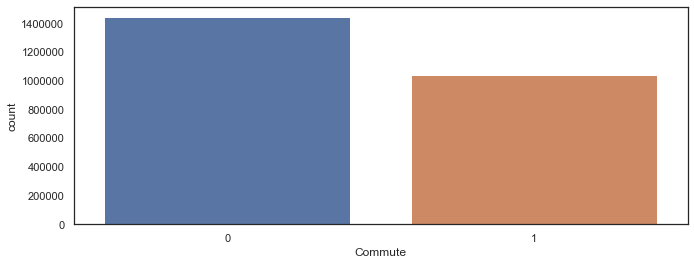

In [95]:
sns.countplot(x = 'Commute',data = train_df_weather)

### Compare Weekday and Weekend Activities

Text(0, 0.5, 'Avg Distance(mile)')

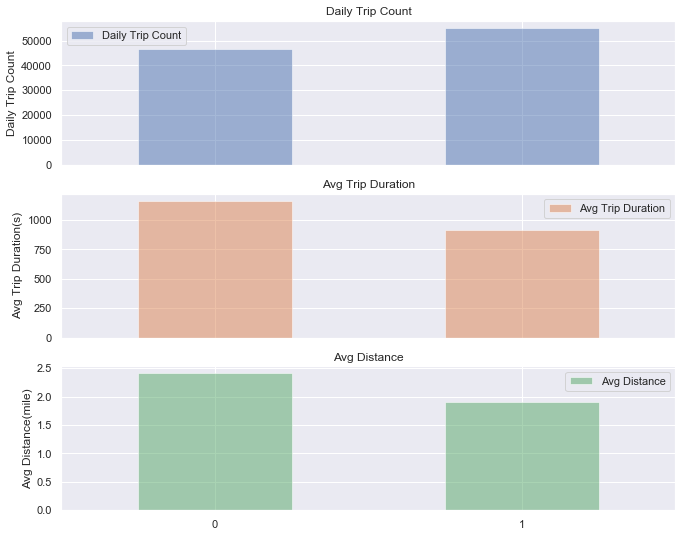

In [108]:
Weekday = train_df_weather[['Isweekday','trip_per_day','daily_avg_trip_duration','daily_avg_distance']]
Weekday.columns =  ['Isweekday','Daily Trip Count','Avg Trip Duration','Avg Distance']
Weekday = Weekday.groupby('Isweekday').agg('mean').reset_index()

sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = Weekday[cols_plot].plot(kind='bar', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True,rot = 0)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

### Check Rush Hours 

In [117]:
# Group by the start_hour and see the frequency correspond to each starting hour
train_df_weather.groupby('start_hour').count()[['trip_duration']].sort_values(by = 'trip_duration', ascending = False).head(6)

,trip_duration
start_hour,
17,266935
18,253655
8,217026
16,193315
19,176140
9,171874


In [214]:
train_df_weather.columns

Index(['trip_duration', 'starttime', 'stoptime', 'start_station_ID',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_ID', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_ID', 'user_type',
       'birth_year', 'gender', 'start_date', 'start_time', 'start_hour',
       'start_min', 'start_year', 'start_month', 'start_dayofweek',
       'stop_date', 'stop_time', 'stop_hour', 'stop_min', 'stop_dayofweek',
       'distance', 'trip_per_day', 'daily_avg_trip_duration',
       'daily_avg_distance', 'trip_per_hour', 'hourly_avg_trip_duration',
       'hourly_avg_distance', 'start_station_checkout_counts',
       'start_station_checkin_counts', 'start_station_bike_added',
       'end_station_checkout_counts', 'end_station_checkin_counts',
       'end_station_bike_added', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'Fog', 'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze', 'TAVG',
       'HasPRCP', 'Ha

In [198]:
# Top 50 stations during rush hours on weekdays
top50_weekdays = train_df_weather.loc[train_df_weather['Isweekday']==1].groupby(['start_station_name']).agg({'trip_duration':'count','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'trip_duration', ascending = False).head(50)
top50_weekdays.head()

,trip_duration,start_station_latitude,start_station_longitude
start_station_name,,,
Pershing Square North,20080,40.751873,-73.977706
Broadway & E 22 St,12975,40.740343,-73.989551
E 17 St & Broadway,12252,40.737050,-73.990093
8 Ave & W 31 St,12053,40.750585,-73.994685
W 21 St & 6 Ave,11610,40.741740,-73.994156


In [212]:
# Top 50 stations on weekends
top50_weekdays_rush_start = train_df_weather.loc[train_df_weather['Commute']==1].groupby(['start_station_name']).agg({'trip_duration':'mean','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'trip_duration', ascending = False).head(50)
top50_weekdays_rush_start.head()

,trip_duration,start_station_latitude,start_station_longitude
start_station_name,,,
Adam Clayton Powell Blvd & W 126 St,28636.608295,40.809495,-73.947765
Myrtle Ave & Marcy Ave,12544.577465,40.695398,-73.949549
Marcus Garvey Blvd & Macon St,10467.397810,40.682601,-73.938037
Verona Pl & Fulton St,10170.922438,40.680356,-73.947679
Putnam Ave & Throop Ave,8925.109333,40.685153,-73.941110


In [207]:
# Top 50 stations on weekends
weekends = train_df_weather.loc[train_df_weather['Isweekday']==0].groupby(['start_station_name']).agg({'trip_per_hour':'mean','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'trip_per_hour', ascending = False).tail(50)
weekends.head()

,trip_per_hour,start_station_latitude,start_station_longitude
start_station_name,,,
Metropolitan Ave & Vandervoort Ave,1.5,40.71429,-73.93323
Van Sinderen Ave & Truxton St,1.5,40.67860,-73.90369
Myrtle Ave & Grove St,1.5,40.69905,-73.91516
Wilson Ave & Troutman St,1.5,40.70166,-73.92754
Norman St & Wyckoff Ave,1.5,40.69517,-73.90311


### Map for dock stations during weekdays and weekends

In [213]:
plt.figure(figsize=(15,10))
plt.plot(top50_weekdays['start_station_longitude'].values, top50_weekdays['start_station_latitude'].values, 'ro',alpha = 0.5,markersize=8)
plt.plot(top50_weekdays_rush_start['start_station_longitude'].values, top50_weekdays_rush_start['start_station_latitude'].values, 'bv',alpha = 0.5,markersize=8)
#plt.plot(top50_weekends['start_station_longitude'].values, top50_weekends['start_station_latitude'].values, 'bv',alpha = 0.5,markersize=8)
mplleaflet.display(tiles='cartodb_positron')

### Check number of stations in different years

In [133]:
# Check number of stations in different years
train_df_weather.loc[train_df_weather.start_year == 2019].start_station_ID.nunique() 
train_df_weather.start_station_ID.nunique() 
# 2017 has 799, 2018 has 812, 2019 has 926, unique stations
# total of 1011 stations 
station_2017 = list(train_df_weather.loc[train_df_weather.start_year == 2017].start_station_ID.unique())
station_2018 = list(train_df_weather.loc[train_df_weather.start_year == 2018].start_station_ID.unique())
station_2019 = list(train_df_weather.loc[train_df_weather.start_year == 2019].start_station_ID.unique())
remove2018 =[item for item in station_2017 if item not in station_2018]
new2018 =[item for item in station_2018 if item not in station_2017]
remove2019 = [item for item in station_2018 if item not in station_2019]
new2019 =[item for item in station_2019 if item not in station_2018]
print('Number of stations removed in 2018: %.f' %len(remove2018))
print('Number of stations removed in 2019: %.f' %len(remove2019))
print('Number of stations added in 2018: %.f' %len(new2018))
print('Number of stations added in 2019: %.f' %len(new2019))

Number of stations removed in 2018: 44
Number of stations removed in 2019: 49
Number of stations added in 2018: 58
Number of stations added in 2019: 163


### Seasonal Trend 

In [20]:
# Time Series of Trip Count
daily_trip = train_df_weather[['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_date')
daily_trip.columns = ['Date','Daily Trip Count','Avg Trip Duration','Avg Distance']
daily_trip = daily_trip.groupby('Date').agg('mean').reset_index().set_index('Date')
daily_trip

,Daily Trip Count,Avg Trip Duration,Avg Distance
Date,,,
2017-01-01,13594,1194.615860,2.474182
2017-01-02,7753,699.582484,1.448913
2017-01-03,13070,1023.747131,2.120294
2017-01-04,32140,775.994742,1.607171
2017-01-05,26518,668.034920,1.383575
...,...,...,...
2019-12-27,28831,986.114391,2.042352
2019-12-28,25378,1074.806289,2.226043
2019-12-29,16182,1144.572921,2.370538


Text(0, 0.5, 'Avg Distance(mile)')

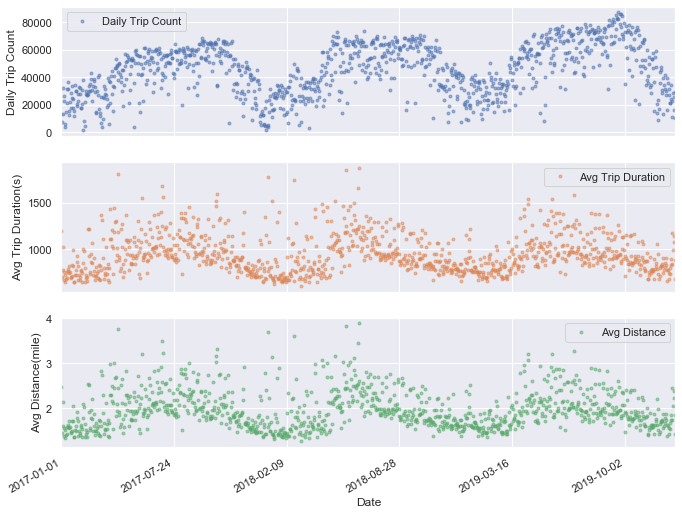

In [21]:
sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = daily_trip[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

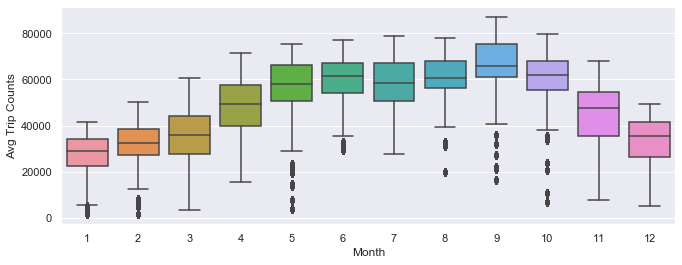

In [22]:
# Trip counts by month
month_trip = train_df_weather[['start_month','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_month')
month_trip.columns=['Month','Avg Trip Counts','Avg Trip Duration','Avg Distance'] 
sns.boxplot(x="Month", y="Avg Trip Counts", data=month_trip)

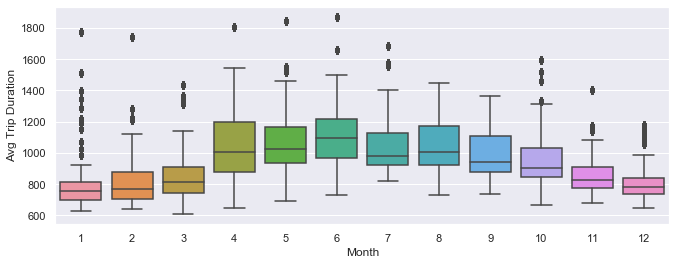

In [23]:
# Trip Duration by Month
sns.boxplot(x="Month", y="Avg Trip Duration",  data=month_trip)

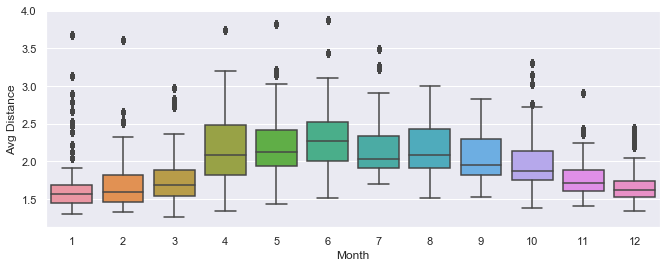

In [24]:
# Trip distance by Month
sns.boxplot(x="Month", y="Avg Distance", data=month_trip)

In [25]:
# sns.distplot(train_df.starttime)

In [28]:
# Non typical checkout (Consider removing them )
train_df_weather.loc[train_df_weather.distance > 10].sort_values(by = 'trip_duration', ascending = False).\
head(20)[['trip_duration', 'starttime', 'stoptime', 'user_type', 'distance']]

,trip_duration,starttime,stoptime,user_type,distance
790733,8096462,2018-02-25 17:06:26.182,2018-05-30 11:07:28.577,Customer,16768.672409
1033792,5891578,2018-06-02 13:13:38.597,2018-08-09 17:46:37.272,Customer,12202.112658
210128,5363062,2017-05-04 15:49:08,2017-07-05 17:33:30,Customer,11107.497298
980106,4602582,2018-05-26 16:42:01.421,2018-07-18 23:11:43.765,Customer,9532.458720
176137,4318433,2017-05-28 16:55:31,2017-07-17 16:29:25,Subscriber,8943.954569
589145,3897730,2017-10-12 15:16:31,2017-11-26 16:58:41,Customer,8072.631911
866420,3653986,2018-04-26 18:27:22.296,2018-06-08 01:27:09.083,Customer,7567.811004
1024611,3553060,2018-06-18 19:32:57.135,2018-07-29 22:30:37.590,Customer,7358.782044
2143411,3341929,2019-08-05 19:53:13.655,2019-09-13 12:12:02.969,Customer,6921.506284
634393,3274876,2017-10-25 16:17:46,2017-12-02 12:59:03,Customer,6782.632071


In [29]:
train_df_weather.loc[(train_df_weather.distance > 10) & (train_df_weather.user_type == 'Subscriber')].shape[0]/\
train_df_weather.loc[(train_df_weather.distance > 10)].shape[0]

0.25863274150705995

In [30]:
14306/2479389

0.005769969940174777

In [31]:
train_df_weather.loc[train_df_weather.user_type == 'Subscriber'].shape[0]/train_df_weather.shape[0]

0.8786289686692972

In [32]:
train_df_weather.loc[train_df_weather.user_type != 'Subscriber'].shape[0]/train_df_weather.shape[0]

0.12137103133070284

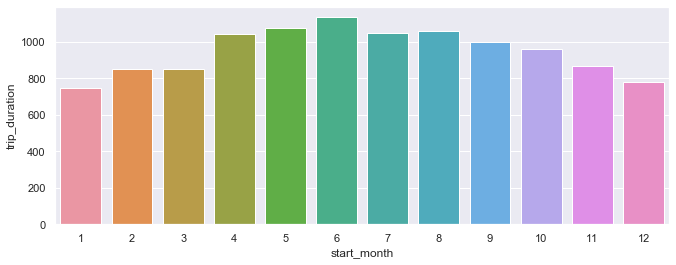

In [33]:
a = train_df_weather.groupby('start_month').mean()[['trip_duration']].reset_index()
sns.barplot(x = a.start_month, y = a.trip_duration)

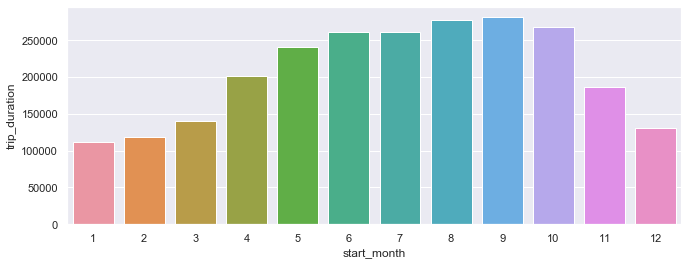

In [34]:
b = train_df_weather.groupby('start_month').count()[['trip_duration']].reset_index()
sns.barplot(x = b.start_month, y = b.trip_duration)

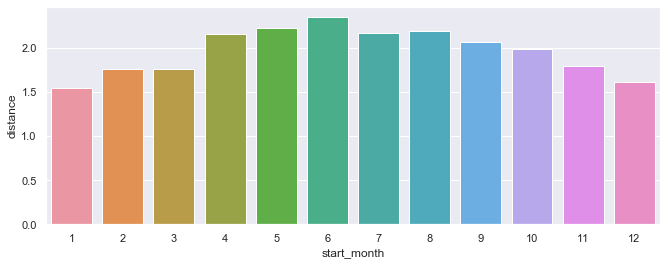

In [35]:
c = train_df_weather.groupby('start_month').mean()[['distance']].reset_index()
sns.barplot(x = c.start_month, y = c.distance)

### Weather Impact

In [43]:
train_df_weather.columns

Index(['trip_duration', 'starttime', 'stoptime', 'start_station_ID',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_ID', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_ID', 'user_type',
       'birth_year', 'gender', 'start_date', 'start_time', 'start_hour',
       'start_min', 'start_year', 'start_month', 'start_dayofweek',
       'stop_date', 'stop_time', 'stop_hour', 'stop_min', 'stop_dayofweek',
       'distance', 'trip_per_day', 'daily_avg_trip_duration',
       'daily_avg_distance', 'trip_per_hour', 'hourly_avg_trip_duration',
       'hourly_avg_distance', 'start_station_checkout_counts',
       'start_station_checkin_counts', 'start_station_bike_added',
       'end_station_checkout_counts', 'end_station_checkin_counts',
       'end_station_bike_added', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'Fog', 'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze', 'TAVG',
       'HasPRCP', 'Ha

In [38]:
# Has PRCP or NOT
train_df_weather.groupby('HasPRCP').agg({'trip_duration': ['count','mean'],'distance':'mean'})

trip_duration               distance
                count         mean      mean
HasPRCP                                     
0             1623976  1006.310433  2.084181
1              855413   941.531893  1.950017

In [39]:
# Has SNOW or NOT
train_df_weather.groupby('HasSNOW').agg({'trip_duration': ['count','mean'],'distance':'mean'})

trip_duration              distance
                count        mean      mean
HasSNOW                                    
0             2445018  987.864005  2.045976
1               34371  706.332053  1.462892

In [42]:
# Has Fog or not 
Fog = train_df_weather[['trip_duration','start_station_bike_added','end_station_bike_added','Fog','Heavy_Fog','distance']]
Fog['HasFog'] = train_df_weather['Fog']+train_df_weather['Heavy_Fog']
Fog.groupby('HasFog').agg({'trip_duration': ['count','mean'],'distance':'mean'})

C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


trip_duration              distance
               count        mean      mean
HasFog                                    
0.0          1468880  989.774963  2.049934
1.0           970111  977.903146  2.025346
2.0            40398  918.049557  1.901383

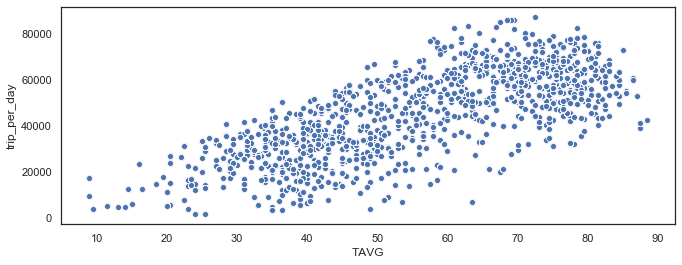

In [62]:
# Avg Temperature
TEMP = train_df_weather[['TAVG','trip_duration','trip_per_day','daily_avg_distance']]
sns.scatterplot(x='TAVG',y='trip_per_day',data = TEMP)

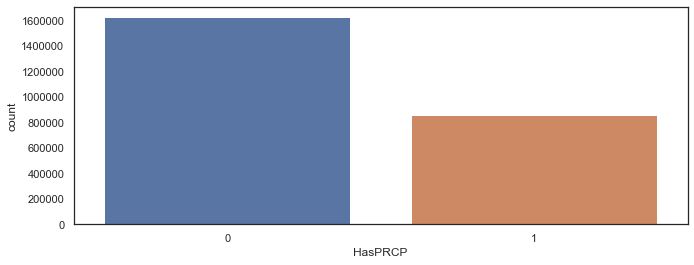

In [65]:
sns.countplot(x='HasPRCP',data=train_df_weather)

In [220]:
train_df_weather.columns

Index(['trip_duration', 'starttime', 'stoptime', 'start_station_ID',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_ID', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_ID', 'user_type',
       'birth_year', 'gender', 'start_date', 'start_time', 'start_hour',
       'start_min', 'start_year', 'start_month', 'start_dayofweek',
       'stop_date', 'stop_time', 'stop_hour', 'stop_min', 'stop_dayofweek',
       'distance', 'trip_per_day', 'daily_avg_trip_duration',
       'daily_avg_distance', 'trip_per_hour', 'hourly_avg_trip_duration',
       'hourly_avg_distance', 'start_station_checkout_counts',
       'start_station_checkin_counts', 'start_station_bike_added',
       'end_station_checkout_counts', 'end_station_checkin_counts',
       'end_station_bike_added', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'Fog', 'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze', 'TAVG',
       'HasPRCP', 'Ha

In [221]:
train_df_weather[['Fog', 'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze']].apply(pd.value_counts)

,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze
0.0,1468880,2438991,2327711,2478978,2471684,2061650
1.0,1010509,40398,151678,411,7705,417739


### Correlation Heat Map

In [224]:
corr['trip_per_day'].sort_values(ascending=False)
# Highly Correlated: Temperature (month), year??  

trip_per_day                     1.000000
TMAX                             0.686773
TAVG                             0.678117
TMIN                             0.651906
start_month                      0.297149
daily_avg_trip_duration          0.283369
daily_avg_distance               0.283369
start_year                       0.272245
start_station_checkin_counts     0.242741
end_station_checkin_counts       0.238330
end_station_checkout_counts      0.238150
start_station_checkout_counts    0.237528
trip_per_hour                    0.237528
bike_ID                          0.079031
Thunder                          0.069687
birth_year                       0.040451
end_station_bike_added           0.036766
end_station_ID                   0.023092
start_station_ID                 0.020455
stop_hour                        0.018329
start_hour                       0.015328
gender                           0.007339
start_station_latitude           0.005623
hourly_avg_distance              0

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

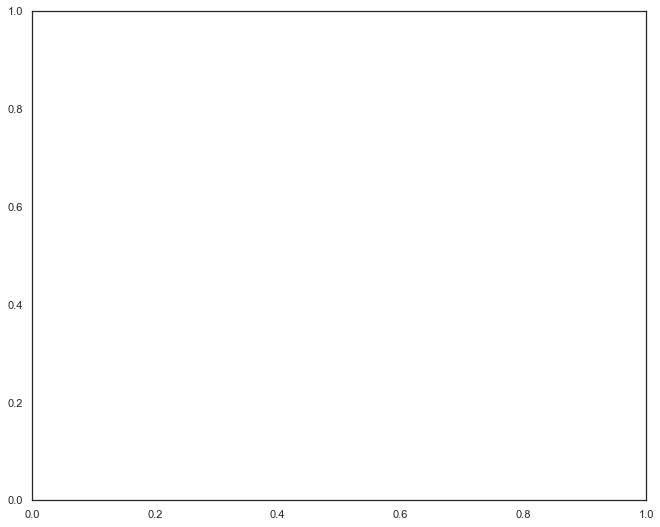

In [53]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns 

sns.set(style="white")
corr =train_df_weather.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [116]:
corr.to_csv('Correlation_Matrix.csv')

In [67]:
corr.dtypes

trip_duration                    float64
start_station_ID                 float64
start_station_latitude           float64
start_station_longitude          float64
end_station_ID                   float64
end_station_latitude             float64
end_station_longitude            float64
bike_ID                          float64
birth_year                       float64
gender                           float64
start_hour                       float64
start_min                        float64
start_year                       float64
start_month                      float64
start_dayofweek                  float64
stop_hour                        float64
stop_min                         float64
stop_dayofweek                   float64
distance                         float64
trip_per_day                     float64
daily_avg_trip_duration          float64
daily_avg_distance               float64
trip_per_hour                    float64
hourly_avg_trip_duration         float64
hourly_avg_dista

In [52]:
corr =train_df_weather.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.